In [1]:
# coding=gbk
import os
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")
import pickle, datetime, copy, ipyparams
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, evaluator, utils_train
import evaluator as ev
from evaluator import Evaluator
from copy import deepcopy


# 文件处理参数
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
## 原始数据文件是否已经更新
if_update = False
## 预处理逻辑(参数)变更/缓存的pickle需要更新时，设为False
####一定要注意利用的数据格式，避免用本月行情预测本月行情。
use_cache = True
version = ipyparams.notebook_name.split('.')[0]

## 预处理参数
if_cls = True
align_to = 'month'
use_lag_x = 15
begT = '2004-01'
endT = datetime.date.today()

## 滚动训练次数
n_splits = 6

<IPython.core.display.Javascript object>

/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, use_lag_x, align_to, begT, endT)
if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

data pickle loaded


In [3]:
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = {}
# 原始的Xy切片之前一定要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]), "\nStart training.......................")
        # 因为每个时间段筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False force_train
        models = utils_train.get_models_dump(X_train, y_train, pipe='cls', version=version, force_train=True, same_model=True)
        models_list[str(X_train.index[-1])]=deepcopy(models)

/nTRAIN period: 2006-12 -> 2016-01 
Start training.......................
...initializing MacroFE


/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


...transforming MacroFE
model 0 pickle saved and appended
...transforming MacroFE
model 1 pickle saved and appended
...transforming MacroFE
model 2 pickle saved and appended
...transforming MacroFE
model 3 pickle saved and appended
...transforming MacroFE
model 4 pickle saved and appended
...transforming MacroFE
model 5 pickle saved and appended
...transforming MacroFE
model 6 pickle saved and appended
...transforming MacroFE
model 7 pickle saved and appended
...transforming MacroFE
model 8 pickle saved and appended
...transforming MacroFE
model 9 pickle saved and appended
/nTRAIN period: 2006-12 -> 2018-03 
Start training.......................
...transforming MacroFE
model 0 pickle saved and appended
...transforming MacroFE
model 1 pickle saved and appended
...transforming MacroFE
model 2 pickle saved and appended
...transforming MacroFE
model 3 pickle saved and appended
...transforming MacroFE
model 4 pickle saved and appended
...transforming MacroFE
model 5 pickle saved and appende

In [4]:
evalor_list = []
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)

        evalor = Evaluator(models_list[str(X_train.index[-1])], if_cls, X_test_long, y_test, y_test_ret, X_train, y_train)
        evalor_list.append(evalor)
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:", str(evalor.excess_ann_ret))
        


TEST period: 2016-02 -> 2018-03 
Start testing...........................

predicting test set for asset 0
...transforming MacroFE
第0个资产的样本外 accuracy score: 0.4230769230769231

predicting test set for asset 1
...transforming MacroFE
第1个资产的样本外 accuracy score: 0.46153846153846156

predicting test set for asset 2
...transforming MacroFE
第2个资产的样本外 accuracy score: 0.5384615384615384

predicting test set for asset 3
...transforming MacroFE
第3个资产的样本外 accuracy score: 0.46153846153846156

predicting test set for asset 4
...transforming MacroFE
第4个资产的样本外 accuracy score: 0.38461538461538464

predicting test set for asset 5
...transforming MacroFE
第5个资产的样本外 accuracy score: 0.3076923076923077

predicting test set for asset 6
...transforming MacroFE
第6个资产的样本外 accuracy score: 0.15384615384615385

predicting test set for asset 7
...transforming MacroFE
第7个资产的样本外 accuracy score: 0.19230769230769232

predicting test set for asset 8
...transforming MacroFE
第8个资产的样本外 accuracy score: 0.4230769230769231

p

In [5]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]

In [6]:
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2016-02 -> 2018-03 的年化超额收益为:
return   -0.131775
dtype: float64
2018-04 -> 2020-05 的年化超额收益为:
return   -0.026774
dtype: float64
2020-06 -> 2022-07 的年化超额收益为:
return   -0.063603
dtype: float64


In [7]:
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0
第0个资产:,0.423077,0.461538,0.307692
第1个资产:,0.461538,0.346154,0.346154
第2个资产:,0.538462,0.538462,0.307692
第3个资产:,0.461538,0.500000,0.269231
第4个资产:,0.384615,0.230769,0.230769
第5个资产:,0.307692,0.346154,0.269231
第6个资产:,0.153846,0.346154,0.269231
第7个资产:,0.192308,0.269231,0.423077
第8个资产:,0.423077,0.269231,0.192308
第9个资产:,0.269231,0.384615,0.307692


In [8]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.3974358974358974
第1个资产:
0.3846153846153846
第2个资产:
0.4615384615384615
第3个资产:
0.4102564102564103
第4个资产:
0.2820512820512821
第5个资产:
0.3076923076923077
第6个资产:
0.2564102564102564
第7个资产:
0.2948717948717949
第8个资产:
0.2948717948717949
第9个资产:
0.32051282051282054


[]

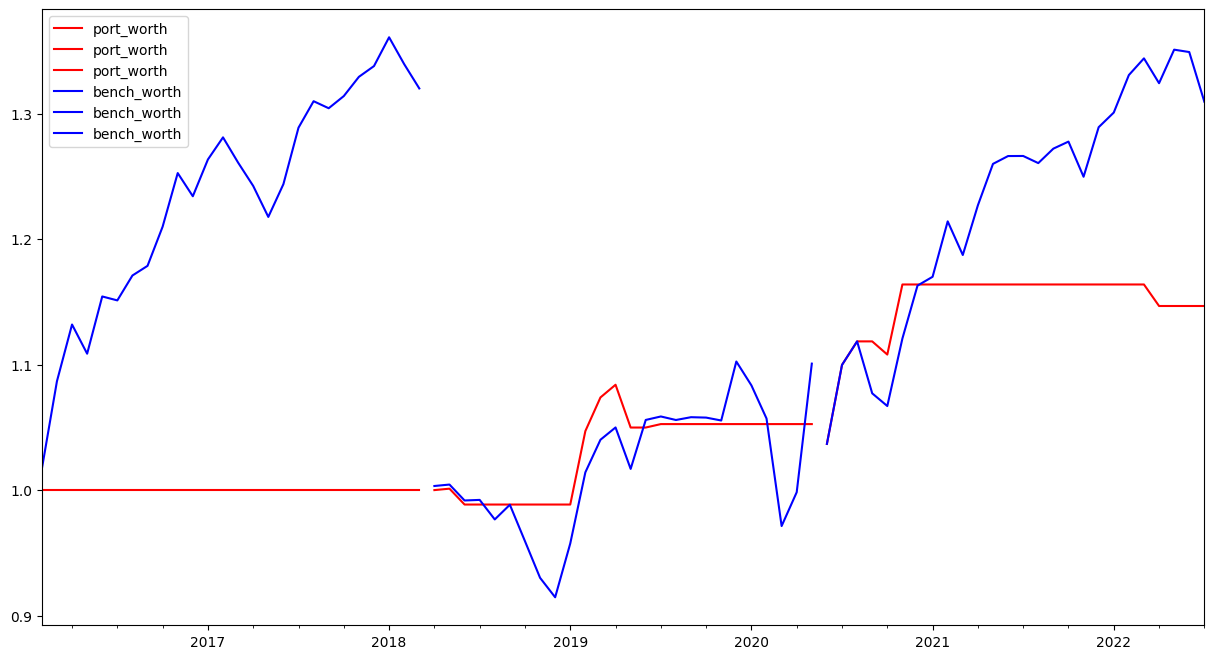

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [10]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

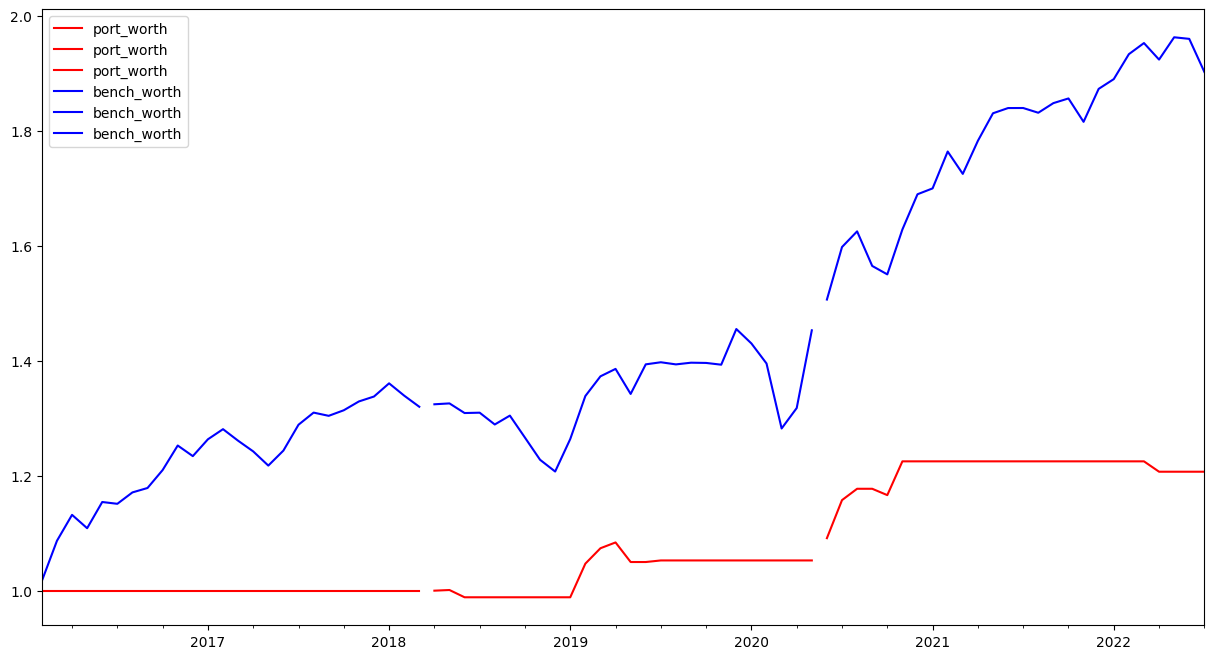

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [12]:
models_list.keys()

dict_keys(['2016-01', '2018-03', '2020-05'])

In [13]:
values=models_list['2016-01'][9][-1][-1].feature_importances_

In [14]:
# values=models_list['2016-01'][9][-1][-1].coef_
# values

In [15]:
names=models_list['2016-01'][9][:-1].get_feature_names_out()
names

array(['lr1__self__lr0__var391(t-10)G0003650_resid',
       'lr1__self__lr0__var584(t-8)S0105896_returns',
       'lr1__self__lr0__var391(t-3)G0003650_resid',
       'lr1__self__ridge0__var391(t-3)G0003650_resid',
       'lr1__self__ridge0__var352(t-1)G1107123_resid',
       'lr1__self__ridge0__var391(t-1)G0003650_resid',
       'lr1__self__sgd0__var391(t-3)G0003650_resid',
       'lr1__self__sgd0__var247(t-1)M5206874_resid',
       'lr1__self__sgd0__var391(t-1)G0003650_resid',
       'lr1__self__rf0__var455(t-4)G0000035_resid', 'lr1__talibFE__8_mom',
       'lr1__talibFE__34_mom', 'lr1__talibFE__50_mom',
       'lr1__talibFE__73_mom', 'lr1__talibFE__88_mom',
       'lr1__talibFE__112_mom', 'lr1__talibFE__133_mom',
       'lr1__talibFE__149_mom', 'lr1__talibFE__172_mom',
       'lr1__talibFE__209_mom',
       'ridge1__self__lr0__var391(t-10)G0003650_resid',
       'ridge1__self__lr0__var584(t-8)S0105896_returns',
       'ridge1__self__lr0__var391(t-3)G0003650_resid',
       'ridge1__se

In [16]:
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])

In [17]:
fea_imp.sort_values(by='values', axis=1, ascending=False)

,90,87,62,61,86,71,72,74,99,92,...,103,102,39,21,24,28,1,33,35,65
names,gbr1__self__gbr0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var397(t-11)G0003891_resid,rf1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__gbr0__var397(t-11)G0003891_resid,gbr1__self__gbr0__var51(t-11)M0000545,rf1__talibFE__121_rsi14,rf1__talibFE__121_rsi6,rf1__talibFE__149_rsi6,gbr1__talibFE__229_rsi14,gbr1__talibFE__121_rsi6,...,mi1__self__mi0__var542(t-13)M0000271_resid,mi1__self__mi0__var528(t-14)M0041653,ridge1__talibFE__209_mom,ridge1__self__lr0__var584(t-8)S0105896_returns,ridge1__self__ridge0__var391(t-3)G0003650_resid,ridge1__self__sgd0__var391(t-1)G0003650_resid,lr1__self__lr0__var584(t-8)S0105896_returns,ridge1__talibFE__50_mom,ridge1__talibFE__133_mom,rf1__talibFE__20_rsi6
values,0.065453,0.065413,0.063973,0.055826,0.052072,0.049672,0.043406,0.038976,0.037782,0.037659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
values=models_list['2018-03'][9][-1][-1].feature_importances_
names=models_list['2018-03'][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

,80,88,82,84,61,93,77,74,95,72,...,45,32,19,52,29,27,65,48,43,30
names,gbr1__self__lr0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var407(t-2)G0003681_resid,gbr1__self__rf0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var140(t-9)M0074413,rf1__self__rf0__var203(t-2)M0000610_resid,gbr1__talibFE__38_rsi14,rf1__talibFE__194_rsi6,rf1__talibFE__188_rsi14,gbr1__talibFE__99_ema12,rf1__talibFE__124_rsi14,...,sgd1__self__sgd0__var50(t-1)M5567963_resid,ridge1__talibFE__129_mom,lr1__talibFE__214_mom,sgd1__talibFE__111_mom,ridge1__talibFE__109_mom,ridge1__talibFE__78_rsi6,rf1__talibFE__39_mom,sgd1__talibFE__44_mom10,sgd1__self__sgd0__var65(t-11)M0000705,ridge1__talibFE__118_mom
values,0.10873,0.084827,0.063846,0.058259,0.047706,0.036323,0.035835,0.035491,0.02861,0.027361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
values=models_list['2020-05'][9][-1][-1].feature_importances_
names=models_list['2020-05'][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

,83,68,69,63,82,89,67,80,64,60,...,52,53,54,55,21,17,8,16,9,100
names,gbr1__self__rf0__var407(t-2)G0003681_resid,rf1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__mi0__var407(t-2)G0003681_resid,rf1__self__ridge0__var385(t-12)G0003663_resid,gbr1__self__rf0__var514(t-6)S0031648_resid,gbr1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__gbr0__var385(t-12)G0003663_resid,gbr1__self__lr0__var339(t-2)G0003878_resid,rf1__self__sgd0__var385(t-12)G0003663_resid,rf1__self__lr0__var385(t-12)G0003663_resid,...,sgd1__talibFE__127_PPO,sgd1__talibFE__139_yoy,sgd1__talibFE__151_mom,sgd1__talibFE__160_yoy,ridge1__self__ridge0__var585(t-15)S0105899_ret...,lr1__talibFE__210_mom,lr1__talibFE__117_mom,lr1__talibFE__193_mom,lr1__talibFE__125_yoy,mi1__self__sgd0__var580(t-5)T1807286_returns
values,0.097162,0.058307,0.055078,0.054822,0.049463,0.048641,0.047905,0.040571,0.038537,0.034387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
